# Demo:  PCA Eigen-Faces

In this demo, you will learn to: 
* Compute the PCA for a simple data set using both the `sklearn PCA` method and an `SVD`.
* Visualize the PCA for images


## Loading the data

We begin by loading the standard packages.

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 14})

We will demonstrate PCA on a face dataset taken from news articles about 10 years ago.  The full data set has thousands of faces, but we will use a small subset here.  Since this data set is widely-used, it is installed as part of the `sklearn`  

We first download the data.  This is large and can take several minutes.

In [ ]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

Once the data is loaded, we can get see the dimensions

In [ ]:
# Get images
n_samples, h, w = lfw_people.images.shape
npix = h*w

# Data in 2D form
X = lfw_people.data
n_features = X.shape[1]

# Labels of images 
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Image size     = {0:d} x {1:d} = {2:d} pixels".format(h,w,npix))
print("Number faces   = {0:d}".format(n_samples))
print("Number classes = {0:d}".format(n_classes))


Image size     = 50 x 37 = 1850 pixels
Number faces   = 1288
Number classes = 7


## Plotting the Faces

We will plot a few faces to look at the dataset.

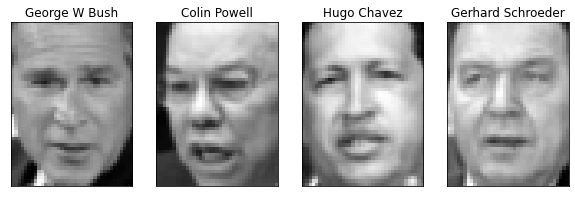

In [ ]:
def plt_face(x):
    h = 50
    w = 37
    plt.imshow(x.reshape((h, w)), cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
    
I = np.random.permutation(n_samples)
plt.figure(figsize=(10,20))
nplt = 4;
for i in range(nplt):    
    ind = I[i]
    plt.subplot(1,nplt,i+1)
    plt_face(X[ind])
    plt.title(target_names[y[ind]])

## Computing the PCA via an SVD

First, we subtract the mean from the data set.

In [ ]:
npix = h*w
Xmean = np.mean(X,0)
Xs = X - Xmean[None,:]

Then, we compute an SVD.  Note that in python the SVD returns `V` not `V.T`.  Also, you should include the `full_matrices` option to get the *economy* SVD

In [ ]:
U,S,Vtr = np.linalg.svd(Xs, full_matrices=False)

We can plot the proportion of variance as a function of the number of PCs.
For an informal proof of how SVD relates to PCA: https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca

Text(0, 0.5, 'PoV')

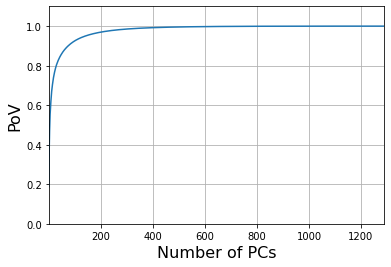

In [ ]:
# lam denotes the eigenvalues, see link above to understand how eigenvalues are a function of singular values
lam = S**2/(n_samples-1)
# PoV denotes percentage of variance explained
PoV = np.cumsum(lam)/np.sum(lam)

plt.plot(PoV)
plt.grid()
plt.axis([1,n_samples,0, 1.1])
plt.xlabel('Number of PCs', fontsize=16)
plt.ylabel('PoV', fontsize=16)

We can now get the PC decomposition of the data:

    X ~= Xhat = Xmean + Z.dot( W ) = Xmean + U*S.dot(Vtr)
    
The terms

*  `Z` is the principal component scores
*  `W` is the principal axes


In [ ]:
nsamp = X.shape[0]
ncomp = 20
Z = U[:,:ncomp]*S[None,:ncomp]

## Computing the PCA with Skelarn PCA Method
We can also compute the PCA with `sklearn` built in method as follow

In [ ]:
from sklearn.decomposition import PCA

# Construct the PCA object
pca = PCA(n_components=ncomp, 
          svd_solver='randomized', whiten=True)

# Fit the PCA components on the entire dataset
pca.fit(X)

PCA(n_components=20, svd_solver='randomized', whiten=True)

When the `whiten` option is set, the `sklearn` method produces *whitened* versions of the components.  Each component is scaled by the `sqrt(nsamp/S[j])` to make sure that the components have mean zero and unit variance.  We can see that the whitened components from the SVD match those from the `PCA`.  There may be a sign change.

In [ ]:
# Note: Zwhiten = U*S*(sqrt(n_samples)/S) = U*sqrt(n_samples)
Zwhiten = U[:,:ncomp]*np.sqrt(nsamp)
Zwhiten_pca = pca.transform(X)

# Print the coefficients for sample 0
print(Zwhiten_pca[0,:5])
print(Zwhiten[0,:5])

[ 0.13230947  0.14949061  0.5200674  -0.09500908 -0.8203606 ]
[-0.13236079 -0.14954892 -0.5202697   0.09504712 -0.8206788 ]


We can also compare the PC axes.  Note that `pca.components_` match the axes with PCA 

In [ ]:
Vtr_pca = pca.components_
print(Vtr_pca[0,:5])
print(Vtr[0,:5])

[-0.00681702 -0.00736357 -0.00855025 -0.01002201 -0.01114254]
[0.00681695 0.00736358 0.00855025 0.01002201 0.01114255]


## Plotting Reconstructed Images from PCs

We now plot the PC reconstructions.  We can use the transforms from the sklearn PCA or the SVD.

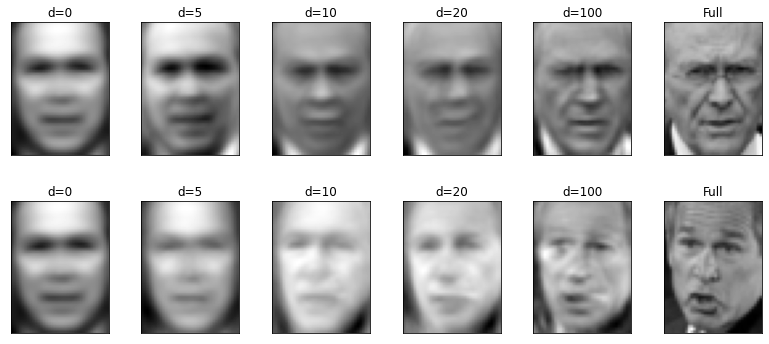

In [ ]:
nplt = 2               # number of faces to plot
ds = [0,5,10,20,100]   # number of SVD approximations
use_pca = True         # True=Use sklearn reconstruction, else use SVD

if use_pca:
    # Construct the PCA object for the max number of coefficient
    dmax = np.max(ds)
    pca = PCA(n_components=dmax, svd_solver='randomized', whiten=True)
    
    # Fit and transform the data
    pca.fit(X)
    Z = pca.transform(X)
    

# Fit the PCA components on the entire dataset
pca.fit(X)

# Select random faces
inds = np.random.permutation(n_samples)
inds = inds[:nplt]
nd = len(ds)

# Set figure size
plt.figure(figsize=(1.8 * (nd+1), 2.4 * nplt))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

# Loop over figures
iplt = 0
for ind in inds:
    for d in ds:
        plt.subplot(nplt,nd+1,iplt+1)
        if use_pca:
            # Zero out coefficients after d.  
            # Note, we need to copy to not overwrite the coefficients
            Zd = np.copy(Z[ind,:])
            Zd[d:] = 0
            Xhati = pca.inverse_transform(Zd)
        else:
            # Reconstruct with SVD
            Xhati = (U[ind,:d]*S[None,:d]).dot(Vtr[:d,:]) + Xmean
            
        plt_face(Xhati)
        plt.title('d={0:d}'.format(d))
        iplt += 1
    
    # Plot the true face
    plt.subplot(nplt,nd+1,iplt+1)
    plt_face(X[ind,:])
    plt.title('Full')
    iplt += 1

Finally, we plot the PCs

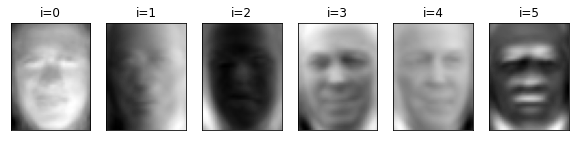

In [ ]:
nplt = 6
plt.figure(figsize=(10, 20))
for i in range(nplt):
    plt.subplot(1,nplt,i+1)
    Vi = Vtr[i,:]
    plt_face(Vtr[i,:])
    plt.title('i={0:d}'.format(i))

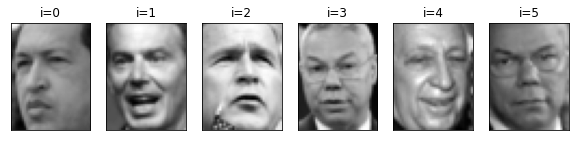

In [ ]:
nplt = 6
plt.figure(figsize=(10, 20))
for i in range(nplt):
    plt.subplot(1,nplt,i+1)
    plt_face(X[i])
    plt.title('i={0:d}'.format(i))